In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from s4_reg.core import s4regressor as regressor
from s4_reg.src_dataloaders_original import StandardScaler
from s4_reg.src_utils_visualize import prediction_result as post

c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\rodin\work\stock_trade\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Informer

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SequenceModel   | 8.7 M 
1 | encoder | Sequential      | 81.9 K
2 | decoder | SequenceDecoder | 1.0 K 
--------------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.058    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Saving latest checkpoint...


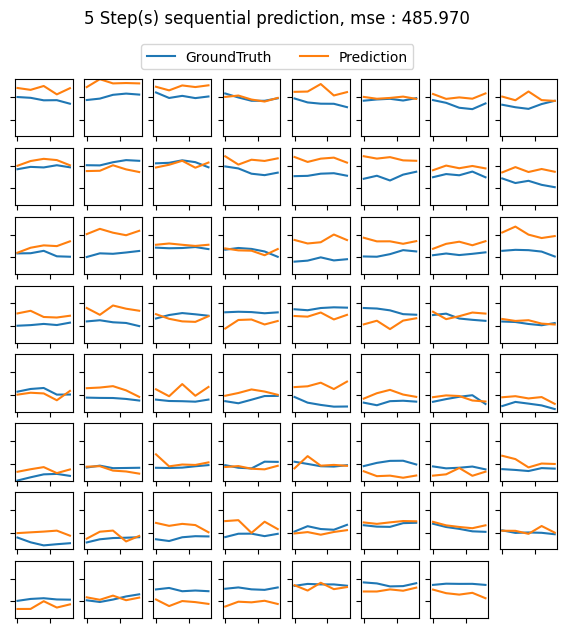

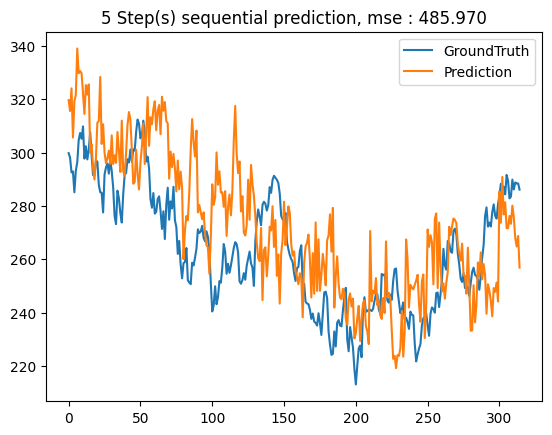

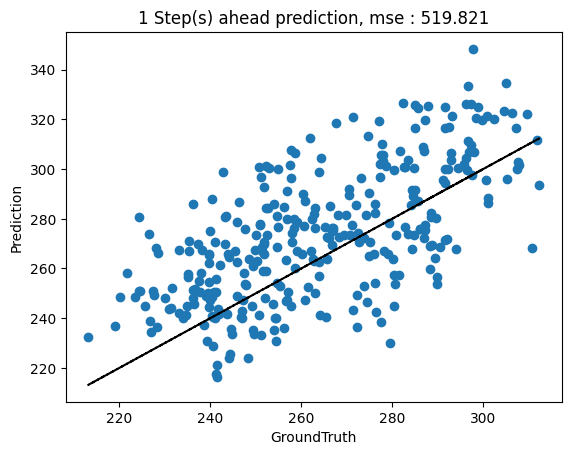

In [5]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 60, 5
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

ckpt = 'null'
max_epochs = 10
batch_size = 10
features = 'S'
train_hippo = False
dropout = 0.4
d_state = 64
n_layers = 4
d_model = 1024
weight_decay = 0.98
lr = 0.0001
valid_ratio = 0.125
patience = 3
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    ckpt = ckpt,
    size = [seq_len, pred_len],
    max_epochs = max_epochs,
    batch_size = batch_size,
    features = features,
    train_hippo = train_hippo,
    dropout = dropout,
    n_layers = n_layers,
    d_state = d_state,
    d_model = d_model,
    lr = lr,
    weight_decay = weight_decay,
    patience = patience,
    valid_ratio = valid_ratio,
    loss_metric = loss_metric,
    device = 'cuda'
)

model.fit()

predictions = model.predict(
    df_test_scaled,
    forecast = True
)

for col in predictions.columns:
    predictions[col] = scaler[target].inverse_transform(predictions[col].values)

trained = post(
    df_test,
    predictions,
    target,
    loss_metric = loss_metric
)

fig_by_pred, _ = trained.val_by_pred(figsize=7)
fig_transition, loss = trained.val_transition()
fig_yy, _ = trained.val_yy(type="discrete")

Informer (d_model=2048, train_hippo=True, seq_len, pred_len = 30, 10)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SequenceModel   | 34.1 M
1 | encoder | Sequential      | 163 K 
2 | decoder | SequenceDecoder | 2.0 K 
--------------------------------------------
34.3 M    Trainable params
0         Non-trainable params
34.3 M    Total params
137.260   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Saving latest checkpoint...


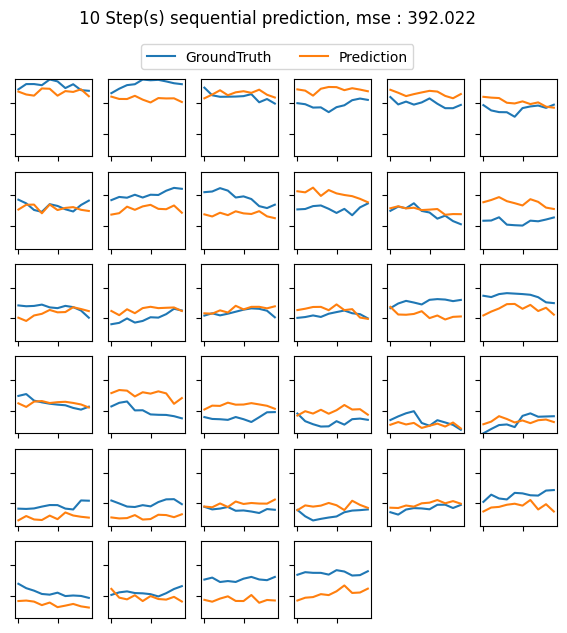

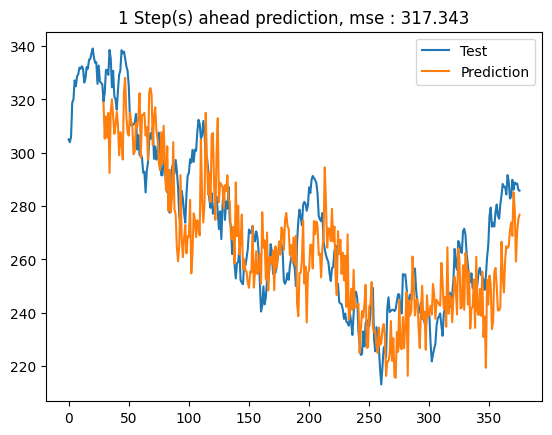

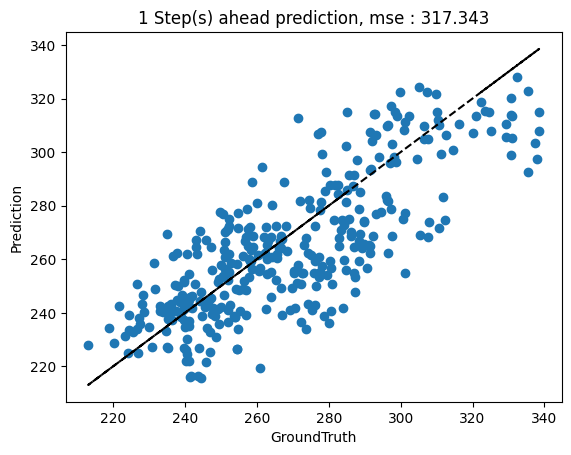

In [4]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 30, 10
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

ckpt = 'null'
max_epochs = 10
batch_size = 10
features = 'S'
train_hippo = True
dropout = 0.4
d_state = 64
n_layers = 4
d_model = 2048
weight_decay = 0.98
lr = 0.0001
valid_ratio = 0.125
patience = 3
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    ckpt = ckpt,
    size = [seq_len, pred_len],
    max_epochs = max_epochs,
    batch_size = batch_size,
    features = features,
    train_hippo = train_hippo,
    dropout = dropout,
    n_layers = n_layers,
    d_state = d_state,
    d_model = d_model,
    lr = lr,
    weight_decay = weight_decay,
    patience = patience,
    valid_ratio = valid_ratio,
    loss_metric = loss_metric,
    device = 'cuda'
)

model.fit()

predictions = model.predict(
    df_test_scaled,
    forecast = True
)

for col in predictions.columns:
    predictions[col] = scaler[target].inverse_transform(predictions[col].values)

trained = post(
    df_test,
    predictions,
    target,
    loss_metric = loss_metric
)

fig_by_pred, _ = trained.val_by_pred(figsize=7)
fig_transition, loss = trained.val_transition(type="discrete")
fig_yy, _ = trained.val_yy(type="discrete")

Informer (d_model=2048, train_hippo=True, seq_len, pred_len = 30, 10, patience=10)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type            | Params
--------------------------------------------
0 | model   | SequenceModel   | 34.1 M
1 | encoder | Sequential      | 163 K 
2 | decoder | SequenceDecoder | 2.0 K 
--------------------------------------------
34.3 M    Trainable params
0         Non-trainable params
34.3 M    Total params
137.260   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 0


Training: 0it [00:00, ?it/s]

Saving latest checkpoint...


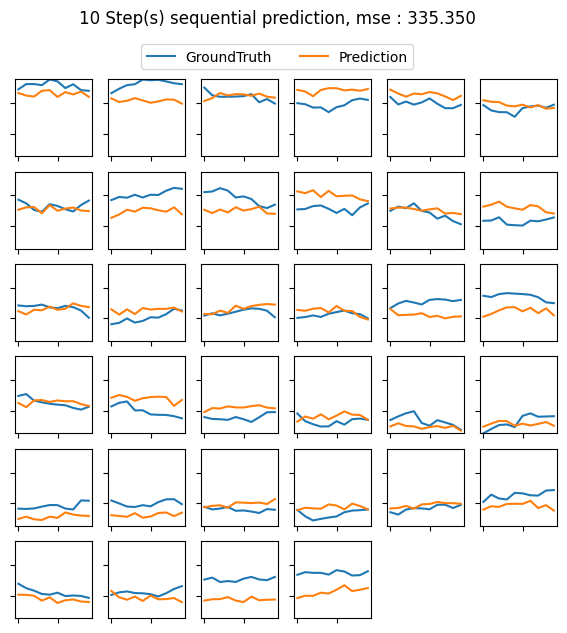

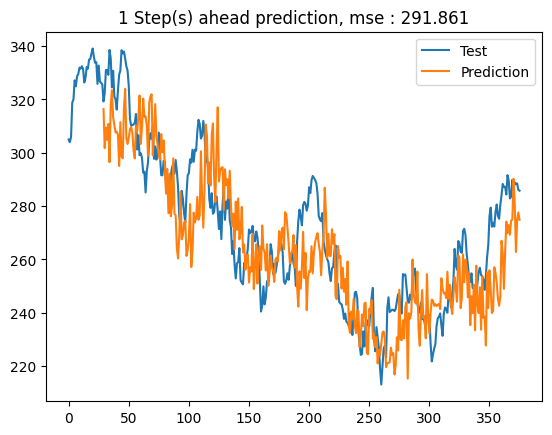

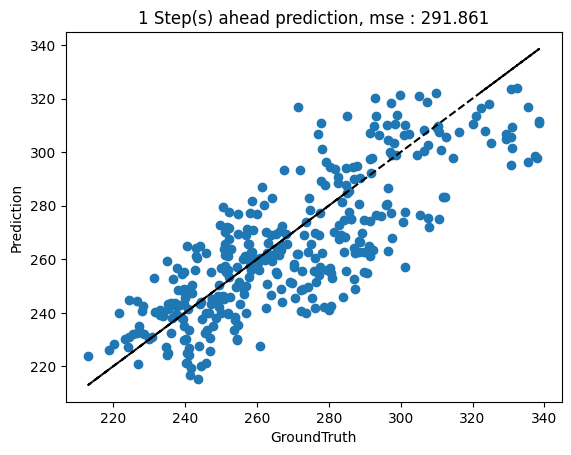

In [10]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 30, 10
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

ckpt = 'null'
max_epochs = 10
batch_size = 10
features = 'S'
train_hippo = True
dropout = 0.4
d_state = 64
n_layers = 4
d_model = 2048
weight_decay = 0.98
lr = 0.0001
valid_ratio = 0.125
patience = 10
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    ckpt = ckpt,
    size = [seq_len, pred_len],
    max_epochs = max_epochs,
    batch_size = batch_size,
    features = features,
    train_hippo = train_hippo,
    dropout = dropout,
    n_layers = n_layers,
    d_state = d_state,
    d_model = d_model,
    lr = lr,
    weight_decay = weight_decay,
    patience = patience,
    valid_ratio = valid_ratio,
    loss_metric = loss_metric,
    device = 'cuda'
)

model.fit()

predictions = model.predict(
    df_test_scaled,
    forecast = True
)

for col in predictions.columns:
    predictions[col] = scaler[target].inverse_transform(predictions[col].values)

trained = post(
    df_test,
    predictions,
    target,
    loss_metric = loss_metric
)

fig_by_pred, _ = trained.val_by_pred(figsize=7)
fig_transition, loss = trained.val_transition(type="discrete")
fig_yy, _ = trained.val_yy(type="discrete")

LightGBM自己回帰

Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.00217509	valid_1's l2: 0.0632811
[100]	training's l2: 0.000269074	valid_1's l2: 0.0583118
[150]	training's l2: 8.39469e-05	valid_1's l2: 0.0581472
[200]	training's l2: 4.10937e-05	valid_1's l2: 0.0580135
[250]	training's l2: 2.37052e-05	valid_1's l2: 0.0579624
[300]	training's l2: 1.39432e-05	valid_1's l2: 0.0579413
[350]	training's l2: 8.85337e-06	valid_1's l2: 0.0579511
[400]	training's l2: 5.31131e-06	valid_1's l2: 0.05793
[450]	training's l2: 3.32094e-06	valid_1's l2: 0.0579223
[500]	training's l2: 2.21954e-06	valid_1's l2: 0.0579233
[550]	training's l2: 1.39234e-06	valid_1's l2: 0.0579146
Early stopping, best iteration is:
[512]	training's l2: 1.96381e-06	valid_1's l2: 0.0579097


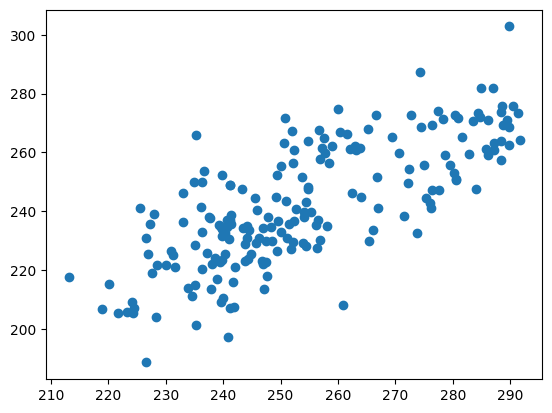

mse : 343.158111539155


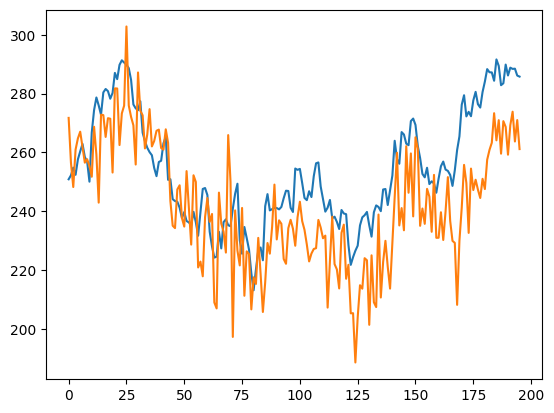

In [6]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cpu'
)

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

feat_df = model.get_features(df_train_scaled).iloc[:-1]
X_train, X_test, y_train, y_test = train_test_split(feat_df.drop([target], axis=1), feat_df[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred_data = model.get_features(df_test_scaled).drop([target], axis=1).iloc[:-1]
s4_pred = lgb_model.predict(s4_pred_data)
s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

No scaling

CUDA extension for Cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for memory efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.53614	valid_1's l2: 17.8167
[100]	training's l2: 0.572578	valid_1's l2: 17.4779
Early stopping, best iteration is:
[67]	training's l2: 1.00243	valid_1's l2: 17.2664


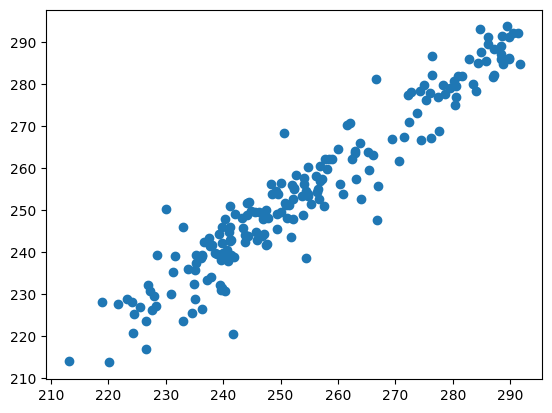

mse : 32.057265118797126


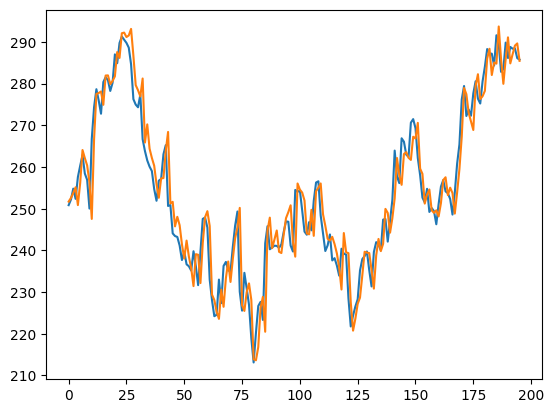

In [4]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
# for col in df_train.columns:
#     if col != 'date':
#         scaler[col] = StandardScaler()
#         scaler[col].fit(data[col].values)
#         df_train_scaled[col] = scaler[col].transform(df_train[col].values)
#         df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cpu'
)

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

feat_df = model.get_features(df_train_scaled).iloc[:-1]
X_train, X_test, y_train, y_test = train_test_split(feat_df.drop([target], axis=1), feat_df[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=1000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred_data = model.get_features(df_test_scaled).drop([target], axis=1).iloc[:-1]
s4_pred = lgb_model.predict(s4_pred_data)
# s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

LightGBM自己回帰＋外生変数

Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.00208384	valid_1's l2: 0.0604349
[100]	training's l2: 0.000408334	valid_1's l2: 0.0558147
[150]	training's l2: 0.000141305	valid_1's l2: 0.0552262
[200]	training's l2: 7.11511e-05	valid_1's l2: 0.055016
[250]	training's l2: 4.06554e-05	valid_1's l2: 0.0548255
[300]	training's l2: 2.17698e-05	valid_1's l2: 0.0548091
[350]	training's l2: 1.32568e-05	valid_1's l2: 0.0547879
[400]	training's l2: 7.89939e-06	valid_1's l2: 0.0547255
[450]	training's l2: 4.82698e-06	valid_1's l2: 0.0547166
[500]	training's l2: 3.39783e-06	valid_1's l2: 0.0547117
[550]	training's l2: 2.14925e-06	valid_1's l2: 0.0546965
[600]	training's l2: 1.47316e-06	valid_1's l2: 0.0546872
[650]	training's l2: 9.53929e-07	valid_1's l2: 0.0546638
[700]	training's l2: 6.2579e-07	valid_1's l2: 0.0546595
[750]	training's l2: 4.10339e-07	valid_1's l2: 0.0546475
[800]	training's l2: 2.85725e-07	valid_1's l2: 0.0546408
[850]	training's l2: 1.91513e-0

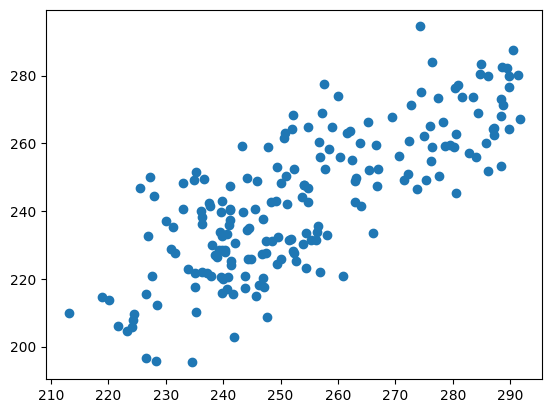

mse : 302.54227516240445


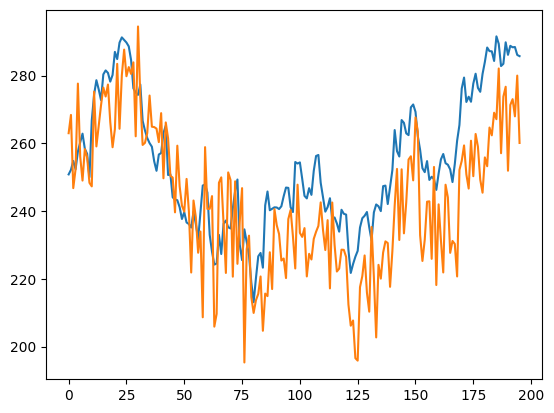

In [21]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
seq_len2, pred_len2 = 10, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cuda'
)

feat_df_train = model.get_features(df_train_scaled).iloc[:-1,:]
feat_df_test = model.get_features(df_test_scaled).iloc[:-1,:]

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len2, pred_len2],
    features = 'MS',
    d_model = 10,
    device = 'cuda'
)
new_col_train = model.get_features(df_train_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_train = new_col_train.drop([target], axis=1)
new_col_train.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_train.columns))]
feat_df_train = pd.concat([feat_df_train, new_col_train], axis=1)

new_col_test = model.get_features(df_test_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_test = new_col_test.drop([target], axis=1)
new_col_test.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_test.columns))]
feat_df_test = pd.concat([feat_df_test, new_col_test], axis=1)

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

X_train, X_test, y_train, y_test = train_test_split(feat_df_train.drop([target], axis=1), feat_df_train[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=2000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred = lgb_model.predict(feat_df_test.drop([target], axis=1))
s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

No Scaling

Training until validation scores don't improve for 50 rounds
[50]	training's l2: 1.60567	valid_1's l2: 17.6109
[100]	training's l2: 0.596395	valid_1's l2: 17.4059
[150]	training's l2: 0.326062	valid_1's l2: 17.4906
Early stopping, best iteration is:
[108]	training's l2: 0.526119	valid_1's l2: 17.3584


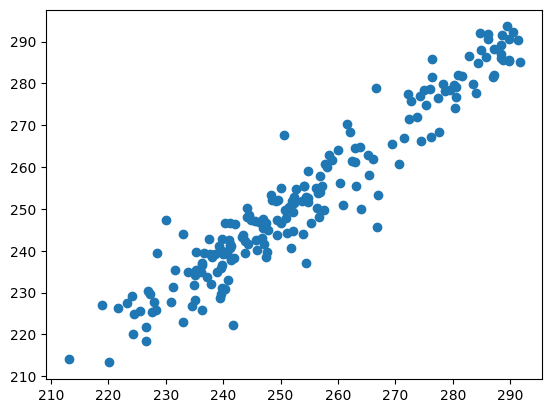

mse : 32.70364977390208


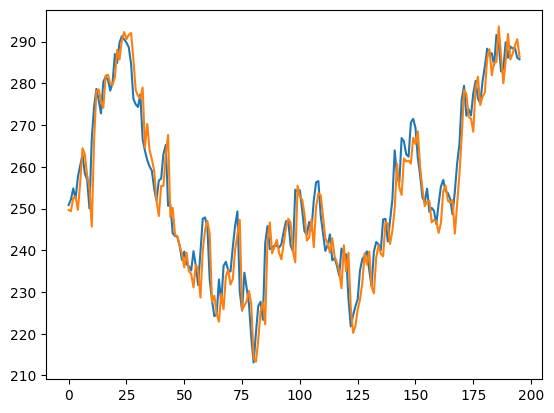

In [6]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
seq_len2, pred_len2 = 10, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
# for col in df_train.columns:
#     if col != 'date':
#         scaler[col] = StandardScaler()
#         scaler[col].fit(data[col].values)
#         df_train_scaled[col] = scaler[col].transform(df_train[col].values)
#         df_test_scaled[col] = scaler[col].transform(df_test[col].values)

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cpu'
)

feat_df_train = model.get_features(df_train_scaled).iloc[:-1,:]
feat_df_test = model.get_features(df_test_scaled).iloc[:-1,:]

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len2, pred_len2],
    features = 'MS',
    d_model = 10,
    device = 'cpu'
)
new_col_train = model.get_features(df_train_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_train = new_col_train.drop([target], axis=1)
new_col_train.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_train.columns))]
feat_df_train = pd.concat([feat_df_train, new_col_train], axis=1)

new_col_test = model.get_features(df_test_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_test = new_col_test.drop([target], axis=1)
new_col_test.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_test.columns))]
feat_df_test = pd.concat([feat_df_test, new_col_test], axis=1)

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

X_train, X_test, y_train, y_test = train_test_split(feat_df_train.drop([target], axis=1), feat_df_train[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=2000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred = lgb_model.predict(feat_df_test.drop([target], axis=1))
# s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

LightGBM自己回帰＋外生変数（num_leaves=10, learning_rate=0.01）

CUDA extension for Cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%


Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.316198	valid_1's l2: 0.356763
[100]	training's l2: 0.166053	valid_1's l2: 0.233586
[150]	training's l2: 0.0887538	valid_1's l2: 0.163336
[200]	training's l2: 0.0489212	valid_1's l2: 0.122216
[250]	training's l2: 0.0275449	valid_1's l2: 0.0941248
[300]	training's l2: 0.0160516	valid_1's l2: 0.0776249
[350]	training's l2: 0.0096449	valid_1's l2: 0.0665255
[400]	training's l2: 0.00610738	valid_1's l2: 0.0589485
[450]	training's l2: 0.00400098	valid_1's l2: 0.0535376
[500]	training's l2: 0.00277841	valid_1's l2: 0.0499923
[550]	training's l2: 0.00202064	valid_1's l2: 0.0470923
[600]	training's l2: 0.00152186	valid_1's l2: 0.0451387
[650]	training's l2: 0.00119303	valid_1's l2: 0.0435012
[700]	training's l2: 0.000968361	valid_1's l2: 0.042489
[750]	training's l2: 0.000798867	valid_1's l2: 0.0418009
[800]	training's l2: 0.000672059	valid_1's l2: 0.0413192
[850]	training's l2: 0.000568962	valid_1's l2: 0.041004

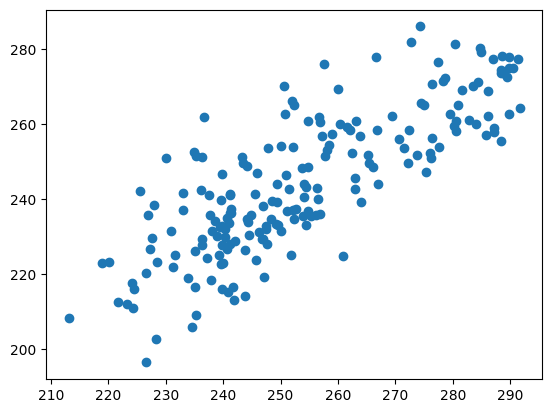

mse : 234.7839076951609


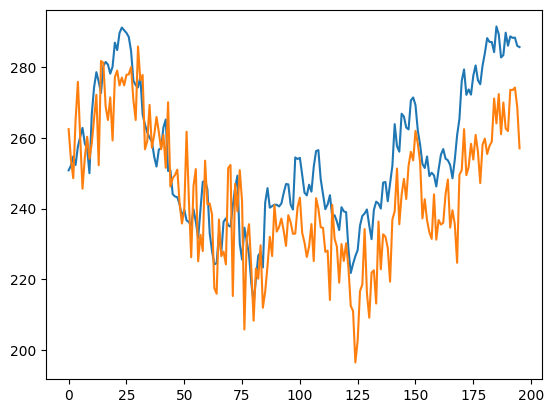

In [3]:
import pickle

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
seq_len2, pred_len2 = 10, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cuda'
)

feat_df_train = model.get_features(df_train_scaled).iloc[:-1,:]
feat_df_test = model.get_features(df_test_scaled).iloc[:-1,:]

model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len2, pred_len2],
    features = 'MS',
    d_model = 10,
    device = 'cuda'
)
new_col_train = model.get_features(df_train_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_train = new_col_train.drop([target], axis=1)
new_col_train.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_train.columns))]
feat_df_train = pd.concat([feat_df_train, new_col_train], axis=1)

new_col_test = model.get_features(df_test_scaled).iloc[seq_len-seq_len2:-1,:]
new_col_test = new_col_test.drop([target], axis=1)
new_col_test.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_test.columns))]
feat_df_test = pd.concat([feat_df_test, new_col_test], axis=1)

params = {
    'objective': 'regression',
    'metric': str(loss_metric),
    'boosting_type': 'gbdt',
    'num_leaves': 10,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'num_threads': -1,
    'seed': 42
}

X_train, X_test, y_train, y_test = train_test_split(feat_df_train.drop([target], axis=1), feat_df_train[target], test_size=0.2, random_state=42)
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test)

lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    num_boost_round=2000,
    early_stopping_rounds=50,
    verbose_eval=50
)

s4_ans = df_test[target].iloc[seq_len:]
s4_pred = lgb_model.predict(feat_df_test.drop([target], axis=1))
s4_pred = scaler[target].inverse_transform(s4_pred)

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred)
print(f'{loss_metric} : {mse}')

LightGBM自己回帰＋逐次推定

Round 878 / 1253
Round 879 / 1253
Round 880 / 1253
Round 881 / 1253
Round 882 / 1253
Round 883 / 1253
Round 884 / 1253
Round 885 / 1253
Round 886 / 1253
Round 887 / 1253
Round 888 / 1253
Round 889 / 1253
Round 890 / 1253
Round 891 / 1253
Round 892 / 1253
Round 893 / 1253
Round 894 / 1253
Round 895 / 1253
Round 896 / 1253
Round 897 / 1253
Round 898 / 1253
Round 899 / 1253
Round 900 / 1253
Round 901 / 1253
Round 902 / 1253
Round 903 / 1253
Round 904 / 1253
Round 905 / 1253
Round 906 / 1253
Round 907 / 1253
Round 908 / 1253
Round 909 / 1253
Round 910 / 1253
Round 911 / 1253
Round 912 / 1253
Round 913 / 1253
Round 914 / 1253
Round 915 / 1253
Round 916 / 1253
Round 917 / 1253
Round 918 / 1253
Round 919 / 1253
Round 920 / 1253
Round 921 / 1253
Round 922 / 1253
Round 923 / 1253
Round 924 / 1253
Round 925 / 1253
Round 926 / 1253
Round 927 / 1253
Round 928 / 1253
Round 929 / 1253
Round 930 / 1253
Round 931 / 1253
Round 932 / 1253
Round 933 / 1253
Round 934 / 1253
Round 935 / 1253
Round 936 / 12

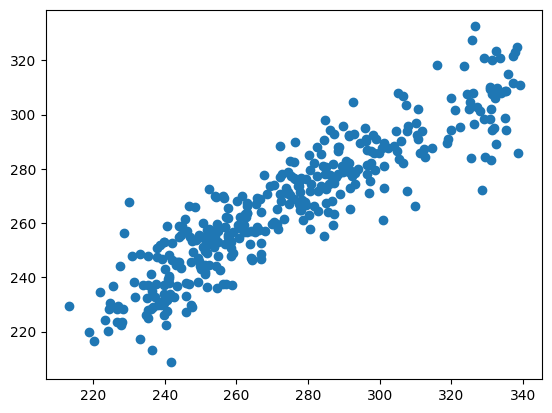

mse : 228.8336503797156


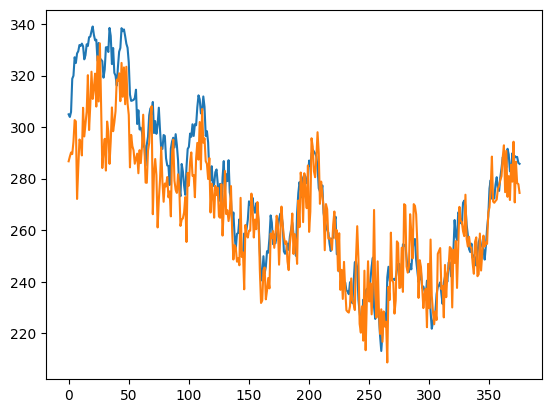

In [9]:
import pickle
    
with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

# data = data.iloc[:300,:] # delete

seq_len, pred_len = 180, 1
features = 'S'
d_model = 1024
loss_metric = 'mse'

scaler = {}
for col in data.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col][:int(len(data)*0.7)])
                
s4_ans_transient = []
s4_pred_transient = []
for i in range(int(len(data)*0.7), len(data)):
    print(f'Round {i+1} / {len(data)}')
    
    df_train = data.iloc[:i,:]
    df_test  = data.iloc[i-seq_len:i,:]

    # Standardize manually
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    for col in df_train.columns:
        if col != 'date':
            df_train_scaled[col] = scaler[col].transform(df_train[col].values)
            df_test_scaled[col] = scaler[col].transform(df_test[col].values)
            
    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len, pred_len],
        features = features,
        d_model = d_model,
        device = 'cuda'
    )

    params = {
        'objective': 'regression',
        'metric': str(loss_metric),
        'boosting_type': 'gbdt',
        'num_leaves': 10,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': -1,
        'seed': 42,
        'force_col_wise' : True # False
    }

    feat_df = model.get_features(df_train_scaled).iloc[:-1,:]
    X_train, X_test, y_train, y_test = train_test_split(feat_df.drop([target], axis=1), feat_df[target], test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test)

    lgb_model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        num_boost_round=2000,
        early_stopping_rounds=50,
        verbose_eval=0
    )

    s4_ans = data[target][i]
    s4_pred_data = model.get_features(df_test_scaled).drop([target], axis=1)
    s4_pred = lgb_model.predict(s4_pred_data)
    s4_pred = scaler[target].inverse_transform(s4_pred)
    s4_pred_transient.append(s4_pred)
    s4_ans_transient.append(s4_ans)
    

mse = mean_squared_error(s4_ans_transient, s4_pred_transient)
plt.scatter(s4_ans_transient, s4_pred_transient)
plt.show()
plt.plot(s4_ans_transient)
plt.plot(s4_pred_transient)
print(f'{loss_metric} : {mse}')

4584.T

Round 878 / 1253
Round 879 / 1253
Round 880 / 1253
Round 881 / 1253
Round 882 / 1253
Round 883 / 1253
Round 884 / 1253
Round 885 / 1253
Round 886 / 1253
Round 887 / 1253
Round 888 / 1253
Round 889 / 1253
Round 890 / 1253
Round 891 / 1253
Round 892 / 1253
Round 893 / 1253
Round 894 / 1253
Round 895 / 1253
Round 896 / 1253
Round 897 / 1253
Round 898 / 1253
Round 899 / 1253
Round 900 / 1253
Round 901 / 1253
Round 902 / 1253
Round 903 / 1253
Round 904 / 1253
Round 905 / 1253
Round 906 / 1253
Round 907 / 1253
Round 908 / 1253
Round 909 / 1253
Round 910 / 1253
Round 911 / 1253
Round 912 / 1253
Round 913 / 1253
Round 914 / 1253
Round 915 / 1253
Round 916 / 1253
Round 917 / 1253
Round 918 / 1253
Round 919 / 1253
Round 920 / 1253
Round 921 / 1253
Round 922 / 1253
Round 923 / 1253
Round 924 / 1253
Round 925 / 1253
Round 926 / 1253
Round 927 / 1253
Round 928 / 1253
Round 929 / 1253
Round 930 / 1253
Round 931 / 1253
Round 932 / 1253
Round 933 / 1253
Round 934 / 1253
Round 935 / 1253
Round 936 / 12

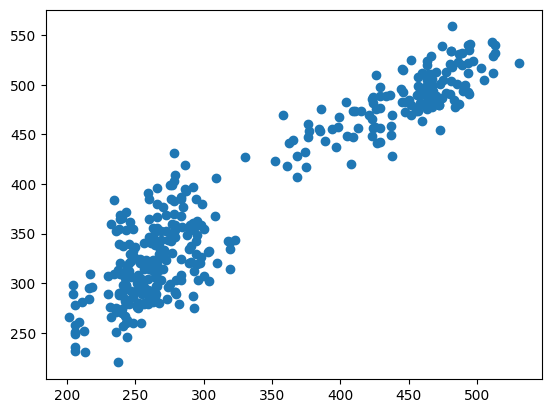

mse : 3653.3972553855347


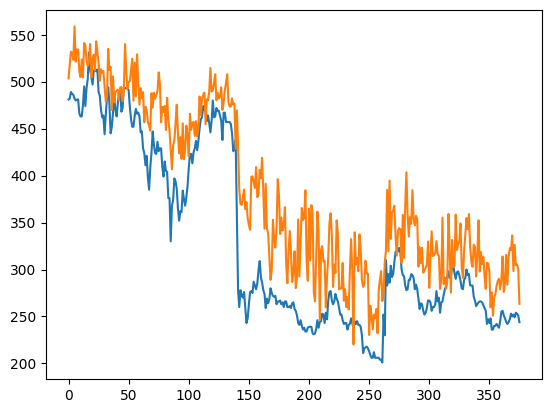

In [11]:
import pickle
    
with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = '4584.T'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

# data = data.iloc[:300,:] # delete

seq_len, pred_len = 180, 1
features = 'S'
d_model = 1024
loss_metric = 'mse'

scaler = {}
for col in data.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col][:int(len(data)*0.7)])
                
s4_ans_transient = []
s4_pred_transient = []
for i in range(int(len(data)*0.7), len(data)):
    print(f'Round {i+1} / {len(data)}')
    
    df_train = data.iloc[:i,:]
    df_test  = data.iloc[i-seq_len:i,:]

    # Standardize manually
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    for col in df_train.columns:
        if col != 'date':
            df_train_scaled[col] = scaler[col].transform(df_train[col].values)
            df_test_scaled[col] = scaler[col].transform(df_test[col].values)
            
    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len, pred_len],
        features = features,
        d_model = d_model,
        device = 'cuda'
    )

    params = {
        'objective': 'regression',
        'metric': str(loss_metric),
        'boosting_type': 'gbdt',
        'num_leaves': 10,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': -1,
        'seed': 42,
        'force_col_wise' : True # False
    }

    feat_df = model.get_features(df_train_scaled).iloc[:-1,:]
    X_train, X_test, y_train, y_test = train_test_split(feat_df.drop([target], axis=1), feat_df[target], test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test)

    lgb_model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        num_boost_round=2000,
        early_stopping_rounds=50,
        verbose_eval=0
    )

    s4_ans = data[target][i]
    s4_pred_data = model.get_features(df_test_scaled).drop([target], axis=1)
    s4_pred = lgb_model.predict(s4_pred_data)
    s4_pred = scaler[target].inverse_transform(s4_pred)
    s4_pred_transient.append(s4_pred)
    s4_ans_transient.append(s4_ans)
    

mse = mean_squared_error(s4_ans_transient, s4_pred_transient)
plt.scatter(s4_ans_transient, s4_pred_transient)
plt.show()
plt.plot(s4_ans_transient)
plt.plot(s4_pred_transient)
print(f'{loss_metric} : {mse}')

LightGBM+外生変数+逐次推定

6000
Round 878 / 1253


CUDA extension for Cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%


Round 879 / 1253
Round 880 / 1253
Round 881 / 1253
Round 882 / 1253
Round 883 / 1253
Round 884 / 1253
Round 885 / 1253
Round 886 / 1253
Round 887 / 1253
Round 888 / 1253
Round 889 / 1253
Round 890 / 1253
Round 891 / 1253
Round 892 / 1253
Round 893 / 1253
Round 894 / 1253
Round 895 / 1253
Round 896 / 1253
Round 897 / 1253
Round 898 / 1253
Round 899 / 1253
Round 900 / 1253
Round 901 / 1253
Round 902 / 1253
Round 903 / 1253
Round 904 / 1253
Round 905 / 1253
Round 906 / 1253
Round 907 / 1253
Round 908 / 1253
Round 909 / 1253
Round 910 / 1253
Round 911 / 1253
Round 912 / 1253
Round 913 / 1253
Round 914 / 1253
Round 915 / 1253
Round 916 / 1253
Round 917 / 1253
Round 918 / 1253
Round 919 / 1253
Round 920 / 1253
Round 921 / 1253
Round 922 / 1253
Round 923 / 1253
Round 924 / 1253
Round 925 / 1253
Round 926 / 1253
Round 927 / 1253
Round 928 / 1253
Round 929 / 1253
Round 930 / 1253
Round 931 / 1253
Round 932 / 1253
Round 933 / 1253
Round 934 / 1253
Round 935 / 1253
Round 936 / 1253
Round 937 / 12

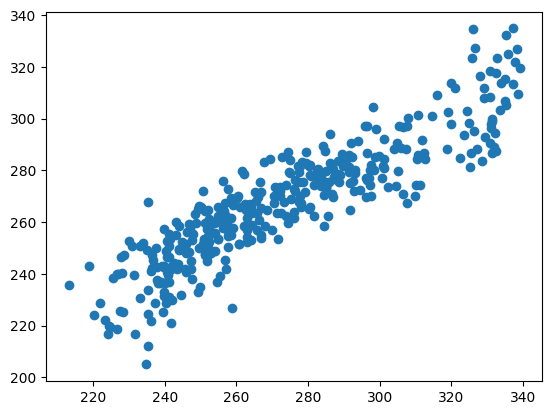

mse : 232.4491395998245
3000


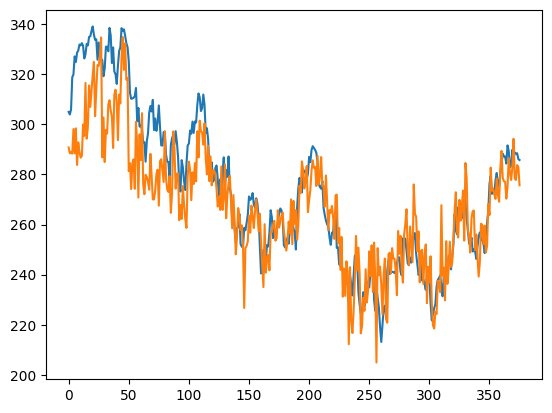

In [3]:
import pickle
import sys
sys.setrecursionlimit(6000)
print(sys.getrecursionlimit())

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

# data = data.iloc[:300,:] # delete

seq_len, pred_len = 180, 1
seq_len2, pred_len2 = 10, 1
features = 'S'
d_model = 2048
loss_metric = 'mse'

scaler = {}
for col in data.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col][:int(len(data)*0.7)])
                
s4_ans_transient = []
s4_pred_transient = []
for i in range(int(len(data)*0.7), len(data)):
    print(f'Round {i+1} / {len(data)}')
    
    df_train = data.iloc[:i,:]
    df_test  = data.iloc[i-seq_len:i,:]

    # Standardize manually
    df_train_scaled = df_train.copy()
    df_test_scaled = df_test.copy()
    for col in df_train.columns:
        if col != 'date':
            df_train_scaled[col] = scaler[col].transform(df_train[col].values)
            df_test_scaled[col] = scaler[col].transform(df_test[col].values)
            
    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len, pred_len],
        features = features,
        d_model = d_model,
        device = 'cuda'
    )

    feat_df_train = model.get_features(df_train_scaled).iloc[:-1,:]
    feat_df_test = model.get_features(df_test_scaled)

    model = regressor(
        dataset = df_train_scaled,
        target = target,
        size = [seq_len2, pred_len2],
        features = 'MS',
        d_model = 10,
        device = 'cuda'
    )
    
    new_col_train = model.get_features(df_train_scaled).iloc[seq_len-seq_len2:-1,:]
    new_col_train = new_col_train.drop([target], axis=1)
    new_col_train.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_train.columns))]
    feat_df_train = pd.concat([feat_df_train, new_col_train], axis=1)

    new_col_test = model.get_features(df_test_scaled).iloc[seq_len-seq_len2:,:]
    new_col_test = new_col_test.drop([target], axis=1)
    new_col_test.columns = [f'exog_feat_{i+1}' for i in range(len(new_col_test.columns))]
    feat_df_test = pd.concat([feat_df_test, new_col_test], axis=1)

    params = {
        'objective': 'regression',
        'metric': str(loss_metric),
        'boosting_type': 'gbdt',
        'num_leaves': 10,
        'learning_rate': 0.01,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'num_threads': -1,
        'seed': 42
    }

    X_train, X_test, y_train, y_test = train_test_split(feat_df_train.drop([target], axis=1), feat_df_train[target], test_size=0.2, random_state=42)
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_test = lgb.Dataset(X_test, label=y_test)

    lgb_model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        num_boost_round=2000,
        early_stopping_rounds=50,
        verbose_eval=0
    )

    s4_ans = data[target][i]
    s4_pred = lgb_model.predict(feat_df_test.drop([target], axis=1))
    s4_pred = scaler[target].inverse_transform(s4_pred)
    s4_pred_transient.append(s4_pred)
    s4_ans_transient.append(s4_ans)

mse = mean_squared_error(s4_ans_transient, s4_pred_transient)
plt.scatter(s4_ans_transient, s4_pred_transient)
plt.show()
plt.plot(s4_ans_transient)
plt.plot(s4_pred_transient)
print(f'{loss_metric} : {mse}')
sys.setrecursionlimit(3000)
print(sys.getrecursionlimit())

Prophet

07:00:42 - cmdstanpy - INFO - Chain [1] start processing
07:00:43 - cmdstanpy - INFO - Chain [1] done processing


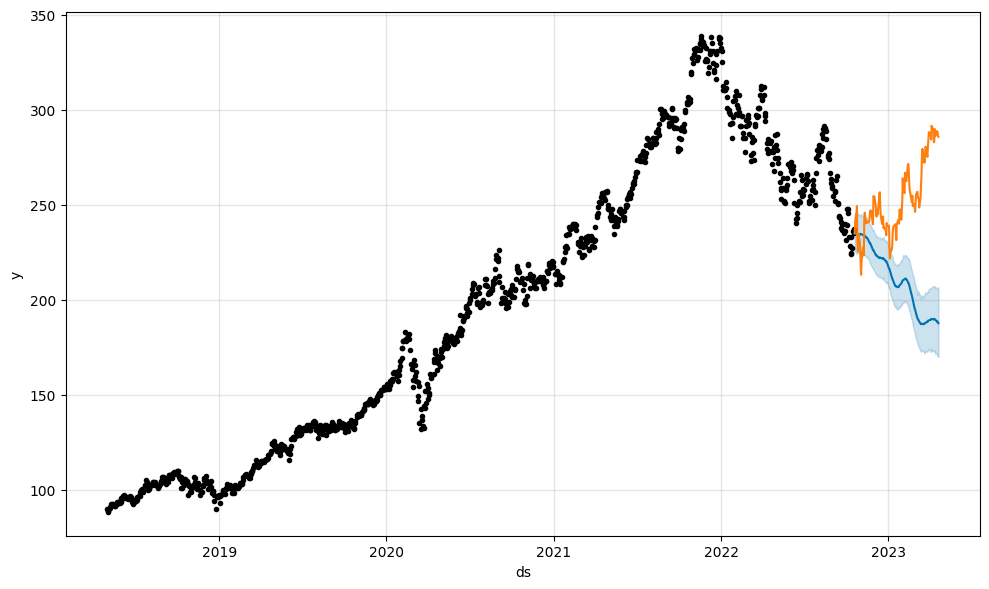

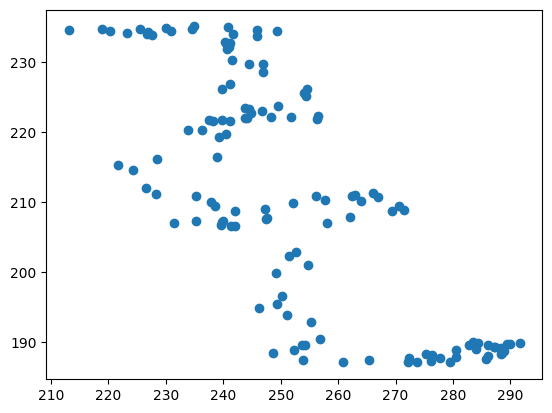

mse : 2889.336174493413


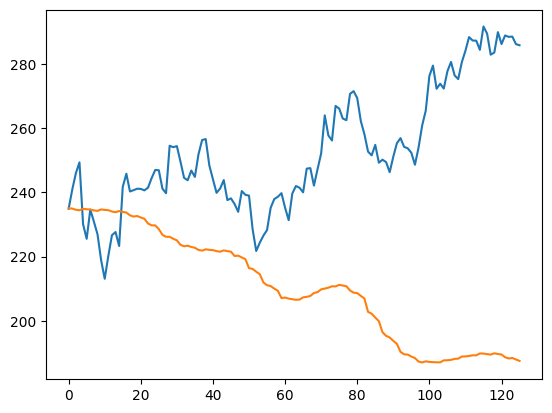

In [16]:
import pickle
from prophet import Prophet

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
df_train = data.iloc[:int(len(data)*0.9),:]
df_test  = data.iloc[int(len(data)*0.9):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

feat_df_train = df_train_scaled
feat_df_test = df_test_scaled

prophet_train = feat_df_train.rename(columns={target:'y', 'date':'ds'})
prophet_test = feat_df_test.rename(columns={target:'y', 'date':'ds'})

model_prophet = Prophet()
model_prophet.fit(prophet_train)
forecast = model_prophet.predict(prophet_test)

model_prophet.plot(forecast)
plt.plot(df_test_scaled['date'], df_test_scaled[target], c='#ff7f0e')
plt.show()

s4_ans = df_test[target]
s4_pred = forecast['yhat']

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred.values)
print(f'{loss_metric} : {mse}')

Prophet+外生変数

21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:31 - cmdstanpy - INFO - Chain [1] done processing


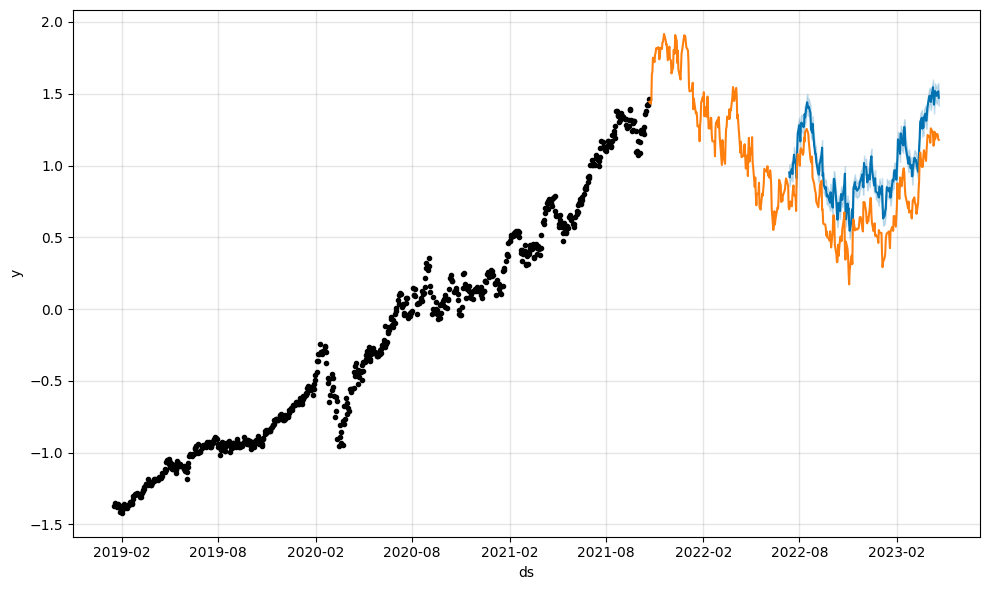

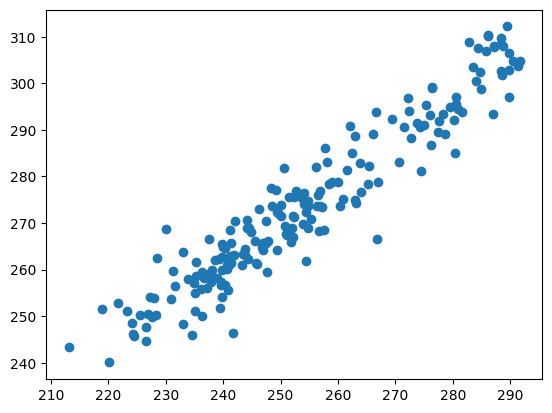

mse : 416.31902696489266


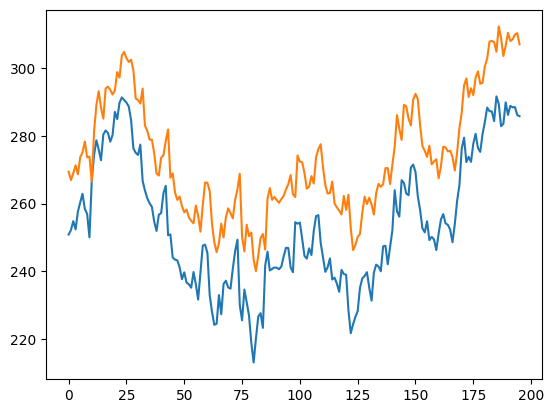

In [41]:
import pickle
from prophet import Prophet

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
for col in df_train.columns:
    if col != 'date':
        scaler[col] = StandardScaler()
        scaler[col].fit(data[col].values)
        df_train_scaled[col] = scaler[col].transform(df_train[col].values)
        df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cuda'
)

feat_df_train = model.get_features(df_train_scaled).iloc[:-1]
feat_df_test = model.get_features(df_test_scaled).iloc[:-1]

feat_df_train = pd.concat([df_train_scaled['date'].iloc[seq_len:], feat_df_train], axis=1)
feat_df_test = pd.concat([df_test_scaled['date'].iloc[seq_len:], feat_df_test], axis=1)

prophet_train = feat_df_train.rename(columns={target:'y', 'date':'ds'})
prophet_test = feat_df_test.rename(columns={target:'y', 'date':'ds'})

model_prophet = Prophet()
for i in prophet_train.drop(['y', 'ds'], axis=1).columns:
    model_prophet.add_regressor(i)

model_prophet.fit(prophet_train)
forecast = model_prophet.predict(prophet_test.drop(['y'], axis=1))

model_prophet.plot(forecast)
plt.plot(df_test['date'], df_test_scaled[target], c='#ff7f0e')
plt.show()

forecast['yhat'] = scaler[target].inverse_transform(forecast['yhat'])
s4_ans = df_test[target].iloc[seq_len:]
s4_pred = forecast['yhat']

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred.values)
print(f'{loss_metric} : {mse}')

No Scaling

CUDA extension for Cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for memory efficiency.
Falling back on slow Vandermonde kernel. Install pykeops for improved memory efficiency.
18:27:36 - cmdstanpy - INFO - Chain [1] start processing
18:27:57 - cmdstanpy - INFO - Chain [1] done processing


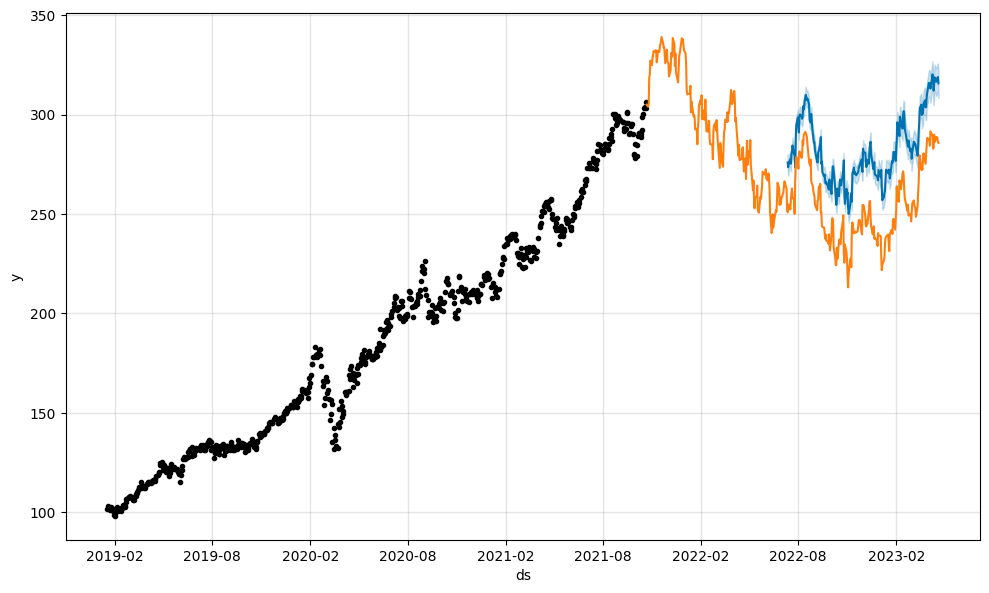

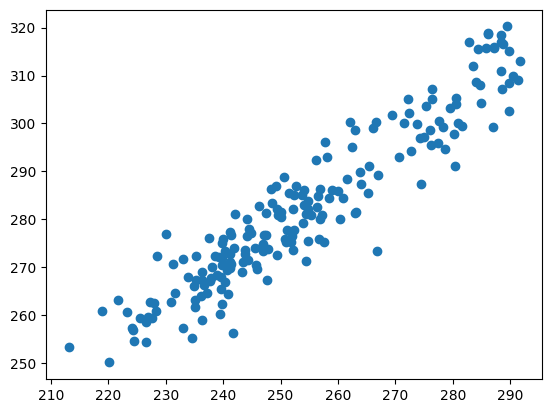

mse : 834.7517655646438


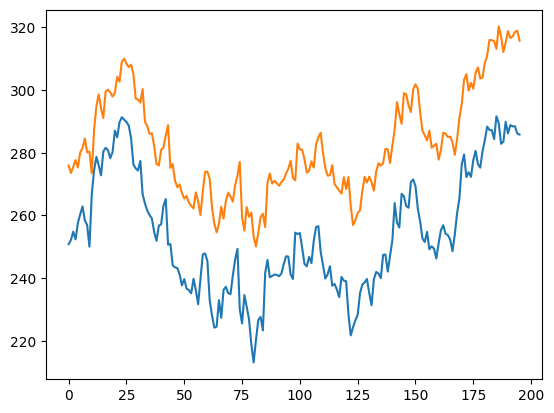

In [4]:
import pickle
from prophet import Prophet

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])
data = data.drop(['Date'],axis=1)

seq_len, pred_len = 180, 1
df_train = data.iloc[:int(len(data)*0.7),:]
df_test  = data.iloc[int(len(data)*0.7):,:]

features = 'S'
d_model = 2048
loss_metric = 'mse'

# Standardize manually
scaler = {}
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()
# for col in df_train.columns:
#     if col != 'date':
#         scaler[col] = StandardScaler()
#         scaler[col].fit(data[col].values)
#         df_train_scaled[col] = scaler[col].transform(df_train[col].values)
#         df_test_scaled[col] = scaler[col].transform(df_test[col].values)
        
model = regressor(
    dataset = df_train_scaled,
    target = target,
    size = [seq_len, pred_len],
    features = features,
    d_model = d_model,
    device = 'cpu'
)

feat_df_train = model.get_features(df_train_scaled).iloc[:-1]
feat_df_test = model.get_features(df_test_scaled).iloc[:-1]

feat_df_train = pd.concat([df_train_scaled['date'].iloc[seq_len:], feat_df_train], axis=1)
feat_df_test = pd.concat([df_test_scaled['date'].iloc[seq_len:], feat_df_test], axis=1)

prophet_train = feat_df_train.rename(columns={target:'y', 'date':'ds'})
prophet_test = feat_df_test.rename(columns={target:'y', 'date':'ds'})

model_prophet = Prophet()
for i in prophet_train.drop(['y', 'ds'], axis=1).columns:
    model_prophet.add_regressor(i)

model_prophet.fit(prophet_train)
forecast = model_prophet.predict(prophet_test.drop(['y'], axis=1))

model_prophet.plot(forecast)
plt.plot(df_test['date'], df_test_scaled[target], c='#ff7f0e')
plt.show()

# forecast['yhat'] = scaler[target].inverse_transform(forecast['yhat'])
s4_ans = df_test[target].iloc[seq_len:]
s4_pred = forecast['yhat']

mse = mean_squared_error(s4_ans, s4_pred)
plt.scatter(s4_ans, s4_pred)
plt.show()
plt.plot(s4_ans.values)
plt.plot(s4_pred.values)
print(f'{loss_metric} : {mse}')

prophet表示用

08:10:00 - cmdstanpy - INFO - Chain [1] start processing
08:10:01 - cmdstanpy - INFO - Chain [1] done processing


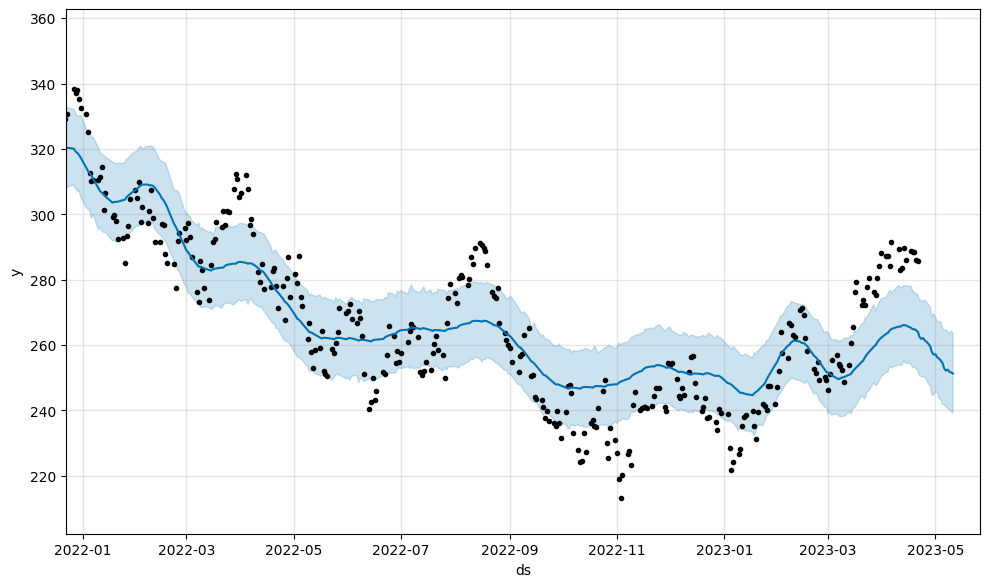

In [77]:
import pickle
from prophet import Prophet
import datetime
import numpy as np

with open("tests/prepared_data.pkl", "rb") as tf:
    dict_prepared_data = pickle.load(tf)

# 4584.T
# 1557.T
# 8789.T
# 1893.T
# MSFT

days=500
periods=20

target = 'MSFT'
data = dict_prepared_data[target].reset_index()
data['date'] = pd.to_datetime(data['Date'])

prophet_train = data.rename(columns={target:'y', 'Date':'ds'})

model_prophet = Prophet()
# model_prophet.add_country_holidays(country_name='JP')
model_prophet.fit(prophet_train)
future = model_prophet.make_future_dataframe(periods=periods)
forecast = model_prophet.predict(future)

model_prophet.plot(forecast)
xmin = datetime.datetime.today() - datetime.timedelta(days=days)
xmax = datetime.datetime.today() + datetime.timedelta(days=periods)
holidays = int(days/30.5*8)
ymin = np.min(forecast['yhat'].iloc[-days+holidays-periods:])
ymax = np.max(forecast['yhat'].iloc[-days+holidays-periods:])
ave  = (ymin + ymax) / 2.0
plt.xlim([xmin, xmax])
plt.ylim([ymin-ave*0.15, ymax+ave*0.15])
plt.show()

prophetで予測値を表示しつつ、s4記述子で強化学習をやってみる。